In [ ]:
import pyvisa
rm = pyvisa.ResourceManager()

resources = rm.list_resources()
print("Available resources:", resources)

scope = rm.open_resource('USB0::0x0AAD::0x01D6::111986::INSTR')

idn = scope.query('*IDN?')
print("Oscilloscope IDN:", idn)

In [ ]:
# Set the file format for the screenshot (e.g., PNG, BMP, etc.)
scope.write('HCOP:DEV:LANG PNG')

In [ ]:
# Send the hardcopy command to capture the screen and transfer it directly
scope.write('HCOP:IMM; *WAI')

In [ ]:
# Fetch the binary data of the screenshot directly
screenshot_data = scope.query_binary_values('HCOP:DATA?', datatype='B', is_big_endian=True)

In [ ]:
# Save the data to a file on your computer
file_path = 'screenshot.png'
with open(file_path, 'wb') as f:
    f.write(bytearray(screenshot_data))

print(f"Screenshot saved to '{file_path}'")

# Close the connection to the oscilloscope
scope.close()

In [ ]:
import pyvisa
import numpy as np
import csv

# Create a VISA resource manager
rm = pyvisa.ResourceManager()

# List all connected devices
resources = rm.list_resources()
print("Available resources:", resources)

# Open a session to your oscilloscope
# Replace 'USB::0x0AAD::0x00C8::123456::INSTR' with the actual resource string for your oscilloscope
resource_name = 'USB0::0x0AAD::0x01D6::111986::INSTR'
scope = rm.open_resource(resource_name)

# Print the IDN of the oscilloscope to verify connection
idn = scope.query('*IDN?')
print("Oscilloscope IDN:", idn)

# Set the timeout to 10 seconds (10000 milliseconds)
scope.timeout = 30000    # Timeout in milliseconds

# Set buffer size (increase if necessary)
scope.read_termination = '\n'
scope.chunk_size = 102400  # 100 KB per chunk

try:
    # Print the IDN of the oscilloscope to verify connection
    idn = scope.query('*IDN?')
    print("Oscilloscope IDN:", idn)

    # Set up the oscilloscope for data acquisition
    # Adjust these settings based on your oscilloscope model and measurement needs
    scope.write('ACQ:TYPE NORM')  # Set acquisition type to normal
    scope.write('WAV:SOUR CHANNEL1')  # Select the waveform source channel
    scope.write('WAV:MODE RAW')  # Set waveform mode to RAW for full data
    scope.write('WAV:FORM BYTE')  # Set data width to 1 byte per sample

    # Fetch waveform data from the oscilloscope
    # Make sure to use correct SCPI commands as per oscilloscope documentation
    print("Fetching waveform data...")
    scope.write('WAV:DATA?')
    
    # Read data in chunks to prevent buffer overflow
    raw_data = b''
    while True:
        try:
            chunk = scope.read_raw()
            raw_data += chunk
            if len(chunk) < scope.chunk_size:
                break
        except pyvisa.errors.VisaIOError as e:
            print("Error reading data:", e)
            break

    # Process the raw data to convert it to actual voltages
    # Use scope queries to get scaling parameters
    y_increment = float(scope.query('WAV:YMULT?'))
    y_offset = float(scope.query('WAV:YZERO?'))
    y_origin = float(scope.query('WAV:YOFF?'))

    x_increment = float(scope.query('WAV:XINC?'))
    x_origin = float(scope.query('WAV:XORIGIN?'))

    # Extract the waveform data starting after the header
    header_length = int(raw_data[1]) + 2
    waveform_data = raw_data[header_length:]

    # Convert the binary data to an array of integers
    waveform_data = np.frombuffer(waveform_data, dtype=np.int8)

    # Calculate the actual time and voltage values
    voltage_data = (waveform_data - y_origin) * y_increment + y_offset
    time_data = np.arange(0, len(voltage_data) * x_increment, x_increment) + x_origin

    # Save the waveform data to a CSV file
    csv_file_path = 'waveform_data.csv'
    with open(csv_file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Time (s)', 'Voltage (V)'])  # Write the header
        csv_writer.writerows(zip(time_data, voltage_data))  # Write the time and voltage data

    print(f"Waveform data saved to '{csv_file_path}'")

except pyvisa.errors.VisaIOError as e:
    print(f"VISA I/O error: {e}")
finally:
    # Close the connection to the oscilloscope
    scope.close()

In [ ]:
from RsInstrument import *

# A good practice is to assure that you have a certain minimum version installed
RsInstrument.assert_minimum_version('1.50.0')
resource_string_1 = 'TCPIP::192.168.2.101::INSTR'  # Standard LAN connection (also called VXI-11)
resource_string_2 = 'TCPIP::192.168.2.101::hislip0'  # Hi-Speed LAN connection - see 1MA208
resource_string_3 = 'GPIB::20::INSTR'  # GPIB Connection
resource_string_4 = 'USB::0x0AAD::0x0119::022019943::INSTR'  # USB-TMC (Test and Measurement Class)
resource_string_5 = 'RSNRP::0x0095::104015::INSTR'  # R&S Powersensor NRP-Z86
resource_string_6 = 'USB0::0x0AAD::0x01D6::111986::INSTR'

# Initializing the session
instr = RsInstrument(resource_string_6)

idn = instr.query_str('*IDN?')
print(f"\nHello, I am: '{idn}'")
print(f'RsInstrument driver version: {instr.driver_version}')
print(f'Visa manufacturer: {instr.visa_manufacturer}')
print(f'Instrument full name: {instr.full_instrument_model_name}')
print(f'Instrument installed options: {",".join(instr.instrument_options)}')

# Close the session
instr.close()

In [ ]:
"""
Event handlers by reading
"""

from RsInstrument import *
import time


def my_transfer_handler(args):
    """Function called each time a chunk of data is transferred"""
    # Total size is not always known at the beginning of the transfer
    total_size = args.total_size if args.total_size is not None else "unknown"

    print(f"Context: '{args.context}{'with opc' if args.opc_sync else ''}', "
            f"chunk {args.chunk_ix}, "
            f"transferred {args.transferred_size} bytes, "
            f"total size {total_size}, "
            f"direction {'reading' if args.reading else 'writing'}, "
            f"data '{args.data}'")

    if args.end_of_transfer:
        print('End of Transfer')
    time.sleep(0.2)


instr = RsInstrument(resource_string_6, True, True)

instr.events.on_read_handler = my_transfer_handler
# Switch on the data to be included in the event arguments
# The event arguments args.data will be updated
instr.events.io_events_include_data = True
# Set data chunk size to 2 bytes
instr.data_chunk_size = 2
instr.query_str('*IDN?')
# Unregister the event handler
instr.events.on_read_handler = None

# Close the session
instr.close()

In [ ]:
"""
Querying ASCII and binary integer arrays
"""

from RsInstrument import *
from time import time

rto = RsInstrument(resource_string_6, True, True)
# Initiate a single acquisition and wait for it to finish
rto.write_str_with_opc("SINGle", 20000)

# Query array of integers in ASCII format
t = time()
waveform = rto.query_bin_or_ascii_int_list('FORM ASC;:CHAN1:DATA?')
print(f'Instrument returned {len(waveform)} points in ASCII format, query duration {time() - t:.3f} secs')


# Query array of integers in Binary format
t = time()
# This tells the RsInstrument in which format to expect the binary integer data
rto.bin_int_numbers_format = BinIntFormat.Integer32_4bytes
# If your instrument sends the data with the swapped endianness, use the following format:
# rto.bin_int_numbers_format = BinIntFormat.Integer32_4bytes_swapped
waveform = rto.query_bin_or_ascii_int_list('FORM INT,32;:CHAN1:DATA?')
print(f'Instrument returned {len(waveform)} points in binary format, query duration {time() - t:.3f} secs')

# Close the rto session
rto.close()

In [ ]:
from RsInstrument import *
instr_list = RsInstrument.list_resources("?*",'rs')
print(instr_list)

In [ ]:
resource_string_1 = 'USB0::0x0AAD::0x01D6::111986::INSTR'
instr = RsInstrument(resource_string_1,id_query=True, reset=True)
idn = instr.query_str('*IDN?')
print(f"\nHello, I am: '{idn}'")
print(f'RsInstrument driver version: {instr.driver_version}')
print(f'Visa manufacturer: {instr.visa_manufacturer}')
print(f'Instrument full name: {instr.full_instrument_model_name}')
print(f'Instrument installed options: {",".join(instr.instrument_options)}')

# Close the session
instr.close()


In [ ]:
from RsInstrument import *

instr = RsInstrument('USB0::0x0AAD::0x01D6::111986::INSTR', True, True)
instr.visa_timeout = 5000
instr.instrument_status_checking = True
instr.write_int('SWEEP:COUNT ', 10)  # sending 'SWEEP:COUNT 10'
instr.write_bool('SOURCE:RF:OUTPUT:STATE ', True)  # sending 'SOURCE:RF:OUTPUT:STATE ON'
instr.write_float('SOURCE:RF:FREQUENCY ', 1E9)  # sending 'SOURCE:RF:FREQUENCY 1000000000'

sc = instr.query_int('SWEEP:COUNT?')  # returning integer number sc=10
out = instr.query_bool('SOURCE:RF:OUTPUT:STATE?')  # returning boolean out=True
freq = instr.query_float('SOURCE:RF:FREQUENCY?')  # returning float number freq=1E9

# Close the session
instr.close()

In [ ]:
from time import time
from RsInstrument import *

rto = RsInstrument('USB0::0x0AAD::0x01D6::111986::INSTR', True, True)

# Initiate a single acquisition and wait for it to finish
rto.write_str_with_opc("SINGle", 20000)

# Query array of floats in ASCII format
t = time()
waveform = rto.query_bin_or_ascii_float_list('FORM ASC;:CHAN1:DATA?')
sns.lineplot(waveform)

print(f'Instrument returned {len(waveform)} points, query duration {time() - t:.3f} secs')

# Close the RTO session
rto.close()

In [ ]:
from RsInstrument import *
from time import time

rto = RsInstrument('USB0::0x0AAD::0x01D6::111986::INSTR', True, True)
# Initiate a single acquisition and wait for it to finish
rto.write_str_with_opc("SINGle", 20000)

# Query array of floats in Binary format
t = time()
# This tells the RsInstrument in which format to expect the binary float data
rto.bin_float_numbers_format = BinFloatFormat.Single_4bytes
# If your instrument sends the data with the swapped endianness, use the following format:
# rto.bin_float_numbers_format = BinFloatFormat.Single_4bytes_swapped
waveform = rto.query_bin_or_ascii_float_list('FORM REAL,32;:CHAN1:DATA?')
sns.lineplot(waveform)
print(f'Instrument returned {len(waveform)} points, query duration {time() - t:.3f} secs')

# Close the RTO session
rto.close()

In [ ]:
import seaborn as sns

In [ ]:
waveform

In [ ]:
from RsInstrument import *
from time import time
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt

# Connect to the oscilloscope
rto = RsInstrument('USB0::0x0AAD::0x01D6::111986::INSTR', True, True)

try:
    # Initiate a single acquisition and wait for it to finish
    rto.write_str_with_opc("SINGle", 20000)

    # Query waveform data
    t = time()
    # This tells the RsInstrument in which format to expect the binary float data
    rto.bin_float_numbers_format = BinFloatFormat.Single_4bytes
    waveform = rto.query_bin_or_ascii_float_list('FORM REAL,32;:CHAN1:DATA?')
    print(f'Instrument returned {len(waveform)} points, query duration {time() - t:.3f} secs')

    # Query time increment and origin for time axis calculation
    try:
        # Fetch timebase settings
        x_increment = float(rto.query(':CHAN1:HOR:MAIN:SCALE?'))  # Horizontal scale
        x_origin = float(rto.query(':CHAN1:HOR:MAIN:POS?'))  # Horizontal position

        # Adjust the scale factor to match your data length
        x_increment /= len(waveform)

        # Calculate time data
        time_data = np.arange(0, len(waveform)) * x_increment + x_origin

    except Exception as e:
        print(f"Error querying time settings: {e}")
        time_data = np.arange(0, len(waveform))  # Default to index-based time data

    # Plot the waveform
    sns.lineplot(x=time_data, y=waveform)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.title('Oscilloscope Waveform')
    plt.show()

    # Save waveform data to CSV file
    csv_file_path = 'waveform_data.csv'
    with open(csv_file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Time (s)', 'Voltage (V)'])  # Write the header
        csv_writer.writerows(zip(time_data, waveform))  # Write the time and voltage data

    print(f"Waveform data saved to '{csv_file_path}'")

finally:
    # Close the RTO session
    rto.close()


In [ ]:
from RsInstrument import *
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt

# Helper function to print VISA resources
def list_visa_resources():
    rm = pyvisa.ResourceManager()
    resources = rm.list_resources()
    print(f"Available VISA resources: {resources}")

# List available VISA resources for debugging
list_visa_resources()

# Connect to the oscilloscope
try:
    rto = RsInstrument('USB0::0x0AAD::0x01D6::111986::INSTR', True, True)
    rto.visa_timeout = 30000  # Set timeout to 30 seconds
    rto.instrument_status_checking = True
    print(f"Connected to: {rto.query('*IDN?')}")

    # Initiate a single acquisition and wait for it to finish
    print("Starting single acquisition...")
    rto.write_str_with_opc("SINGle", 20000)

    # Query waveform data
    print("Fetching waveform data...")
    rto.bin_float_numbers_format = BinFloatFormat.Single_4bytes
    waveform = rto.query_bin_or_ascii_float_list('FORM REAL,32;:CHAN1:DATA?')
    print(f'Instrument returned {len(waveform)} points')

    # Query horizontal settings for time axis calculation
    try:
        print("Fetching time axis settings...")
        x_increment = float(rto.query(':TIMebase:SCALe?'))  # Time scale
        x_origin = float(rto.query(':TIMebase:POSition?'))  # Time position

        # Calculate time data
        time_data = np.arange(0, len(waveform)) * x_increment + x_origin

    except Exception as e:
        print(f"Error querying time settings: {e}")
        time_data = np.arange(0, len(waveform))  # Default to index-based time data

    # Plot the waveform
    sns.lineplot(x=time_data, y=waveform)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.title('Oscilloscope Waveform')
    plt.show()

    # Save waveform data to CSV file
    csv_file_path = 'waveform_data.csv'
    with open(csv_file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Time (s)', 'Voltage (V)'])  # Write the header
        csv_writer.writerows(zip(time_data, waveform))  # Write the time and voltage data

    print(f"Waveform data saved to '{csv_file_path}'")

except RsInstrException as e:
    print(f"Instrument error: {e}")
except pyvisa.errors.VisaIOError as e:
    print(f"VISA I/O error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")
finally:
    # Close the RTO session
    if 'rto' in locals():
        rto.close()

# rto.close()

9.2e-09


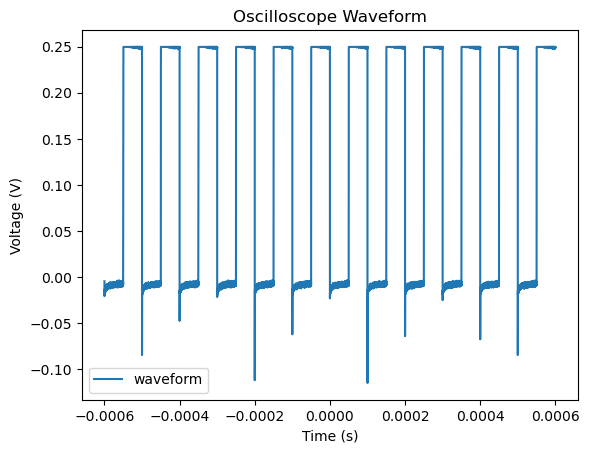

In [31]:
from RsInstrument import *
from time import time
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Connect to the oscilloscope
rto = RsInstrument('USB0::0x0AAD::0x01D6::111986::INSTR', True, True)

# Initiate a single acquisition and wait for it to finish
rto.write_str_with_opc("SINGle", 50000)

# Query array of floats in ASCII format
t = time()
waveform = rto.query_bin_or_ascii_float_list('FORM ASC;:CHAN1:DATA?')

# Fetch timebase settings
x_increment = float(rto.query('CHAN1:DATA:XINC?'))  # Horizontal scale
print(x_increment)
x_origin = float(rto.query('CHAN1:DATA:XOR?'))  # Horizontal positio
# Adjust the scale factor to match your data length
# x_increment /= len(waveform)
# # Calculate time data
time_data = np.arange(0, len(waveform)) * x_increment + x_origin

rto.close()

# data plotting
data = pd.DataFrame({
    'time_data': time_data,
    'waveform': waveform
})

data.plot(x='time_data', y='waveform', xlabel='Time (s)', ylabel='Voltage (V)', title='Oscilloscope Waveform')
plt.show()